In [23]:
import os
import glob
from pathlib import Path

import requests
import difflib
import random


import json
import csv
import numpy as np
import pandas as pd 
import sklearn as sk 
import umap
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn import preprocessing
import matplotlib.pyplot as plt
#%matplotlib notebook
import mplcursors
from ipywidgets import widgets
from ipywidgets import GridspecLayout
from ipywidgets import interactive
from ipywidgets import interact

In [24]:
#get data 
os.getcwd()
os.listdir('./transformed-data/')

filepath = "./transformed-data/aggdf.csv"
df = pd.read_csv(filepath)
print(df.columns)

Index(['player', 'aces', 'bk_pts', 'bp_saved', 'crosscourt', 'deep', 'dfs',
       'down_middle', 'down_the_line', 'err_deep', 'err_net', 'err_wide',
       'err_wide_deep', 'first_aces', 'first_forced', 'first_in', 'first_pts',
       'first_pts_won', 'first_unret', 'first_won', 'first_won_lte_3_shots',
       'forced_err', 'in_play', 'in_play_won', 'induced_forced', 'inside_in',
       'inside_out', 'net_pts', 'net_unforced', 'net_winner', 'passed_at_net',
       'passing_shot_induced_forced', 'pt_ending', 'pts', 'pts_won',
       'pts_won_lte_3_shots', 'return_forced', 'return_pts', 'return_pts_won',
       'returnable', 'returnable_won', 'second_aces', 'second_forced',
       'second_in', 'second_pts', 'second_pts_won', 'second_unret',
       'second_won', 'second_won_lte_3_shots', 'serve_pts', 'serve_return',
       'shallow', 'shots', 'shots_in_pts_lost', 'shots_in_pts_won', 'snv_pts',
       'total_shots', 'unforced', 'unforced_bh', 'unforced_fh', 'unret',
       'very_deep', 'w

In [25]:
# split player labels and attributes
X = df.loc[:, df.columns != 'player']
labels = df['player']

# params for cluster
eps = 0.025
min_samples= 1

In [26]:
# checkbox widget
def multi_checkbox_widget(descriptions):
    """ Widget with a search field and lots of checkboxes """
    search_widget = widgets.Text()
    options_dict = {description: widgets.Checkbox(description=description, value=False) for description in descriptions}
    options = [options_dict[description] for description in descriptions]
    options_widget = widgets.VBox(options, layout={'overflow': 'scroll'})
    multi_select = widgets.VBox([search_widget, options_widget])

    # Wire the search field to the checkboxes
    def on_text_change(change):
        search_input = change['new']
        if search_input == '':
            # Reset search field
            new_options = [options_dict[description] for description in descriptions]
        else:
            # Filter by search field using difflib.
            close_matches = difflib.get_close_matches(search_input, descriptions, cutoff=0.0)
            new_options = [options_dict[description] for description in close_matches]
        options_widget.children = new_options

    search_widget.observe(on_text_change, names='value')
    return multi_select

# Example of using the widget

# Get lots of words for our options
words_url = 'https://svnweb.freebsd.org/csrg/share/dict/words?view=co&content-type=text/plain'
response = requests.get(words_url)
response.raise_for_status()
#words = response.text
#words = set([word.lower() for word in words.splitlines()])
descriptions = df.columns[1:-1] #random.sample(words, 100)

checkboxes = multi_checkbox_widget(descriptions)

In [27]:
# button event
def handle_button_submit(sender):
    selected_options = [w.description for w in checkboxes.children[1].children if w.value]
    if(len(selected_options) == 0):
        selected_options = [w.description for w in checkboxes.children[1].children] # use everything if empty
    X = df[selected_options]
    x = df.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(X)
    X_scaled = pd.DataFrame(x_scaled)
    
    #cluster
    dbscan = DBSCAN(eps=eps,min_samples=min_samples)
    clusterlabels = dbscan.fit_predict(X_scaled)
    
    
    #dimension reduction
    pca = sk.decomposition.PCA(n_components = 2)
    pca.fit(X)
    data = pca.transform(X)
    
    #split data
    x = data[:,0]
    y = data[:,1]
    c = clusterlabels
    maximum = np.max(c)
    minimum = np.min(c)
    
    # update plot
    norm = plt.Normalize(1,4)
    cmap = plt.cm.Spectral #RdYlGn

    fig,ax = plt.subplots()
    sc = plt.scatter(x,y,c=c, s=100, cmap=cmap, norm=norm)

    annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                        bbox=dict(boxstyle="round", fc="w"),
                        arrowprops=dict(arrowstyle="->"))
    annot.set_visible(False)
    fig.canvas.mpl_connect("motion_notify_event", hover)
    fig.set_size_inches(9,8)
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('PCA test for reduction to 2 components')
    plt.show()
    plt.clim(minimum, maximum)
    

#button widget
button = widgets.Button(
    description='Confirm',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)
button.on_click(handle_button_submit)

In [28]:
#Text search player event
def handle_text_submit(sender):
    idx = labels[labels==text.value]
    point = None
    if(len(idx)>0):
        pointidx = idx.index[0]
        point = data[pointidx]
    print(text.value,": ",point)
    
    
# #Text search player widget
text = widgets.Text()
text.on_submit(handle_text_submit)

In [29]:
# plot hover event
def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()

GridspecLayout(children=(VBox(children=(Text(value=''), VBox(children=(Checkbox(value=False, description='aces…

<IPython.core.display.Javascript object>


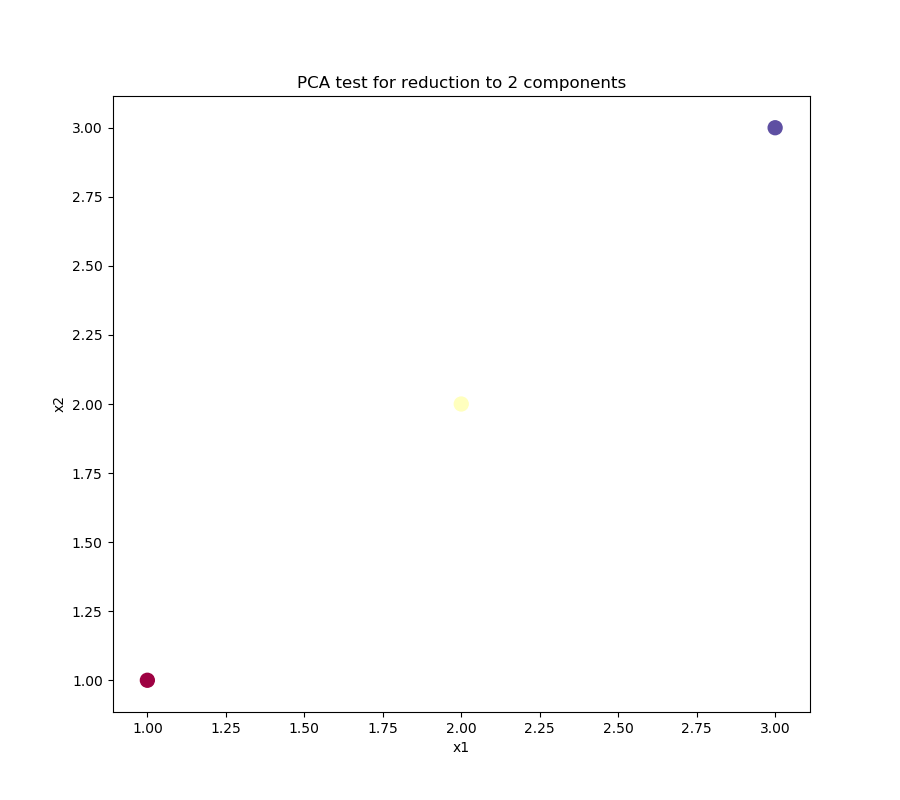

In [32]:
#default params
x = [1,2,3]
y = [1,2,3]
c = y
maximum = np.max(c)
minimum = np.min(c)


# grid
grid = GridspecLayout(1, 3)
grid[0, 0] = checkboxes
grid[0, 1] = button
grid[0, 2] = text

display(grid)

norm = plt.Normalize(1,4)
cmap = plt.cm.Spectral #RdYlGn

fig,ax = plt.subplots()
sc = plt.scatter(x,y,c=c, s=100, cmap=cmap, norm=norm)

annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)
fig.canvas.mpl_connect("motion_notify_event", hover)
fig.set_size_inches(9,8)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('PCA test for reduction to 2 components')
plt.show()
plt.clim(minimum, maximum)

sources
<br>

<br>